# Free Fall

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          198     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.77228D+04    |proj g|=  9.05767D+01

At iterate    1    f=  7.17631D-09    |proj g|=  1.10093D-01

At iterate    2    f=  1.14527D-11    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  198      2      4      3     0     0   0.000D+00   1.145D-11
  F =   1.1452660596444477E-011

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


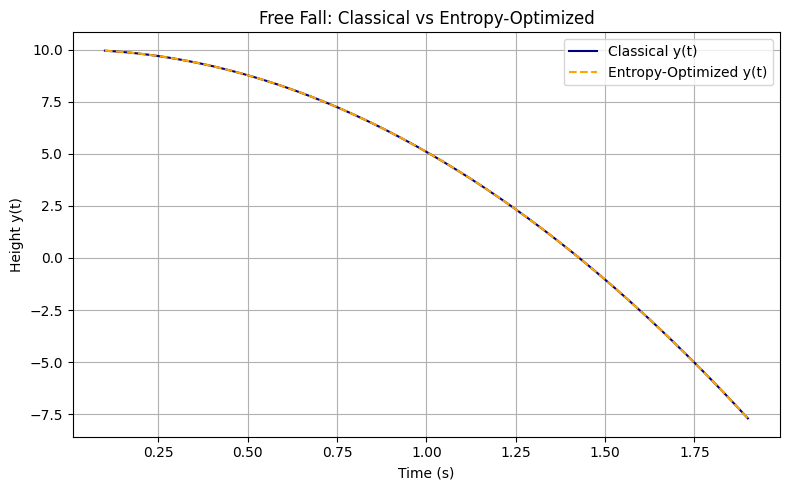

Entropy Loss (Classical): 1.772283e+04
Entropy Loss (Optimized): 1.145266e-11
ΔLoss: -1.772283e+04


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# ------------------------------------------
# 1. Physical Parameters
# ------------------------------------------
m = 1.0       # mass (kg)
g = 9.81      # gravity (m/s^2)
t_start, t_end = 0.0, 2.0
N = 200
t_eval = np.linspace(t_start, t_end, N)
dt = t_eval[1] - t_eval[0]

# ------------------------------------------
# 2. Classical Free Fall ODE Solver
# ------------------------------------------
def free_fall_ode(t, y):
    pos, vel = y
    return [vel, -g]

y0 = 10.0     # initial height (m)
v0 = 0.0      # initial velocity (m/s)
sol = solve_ivp(free_fall_ode, [t_start, t_end], [y0, v0], t_eval=t_eval)
y_classical = sol.y[0]

# ------------------------------------------
# 3. Entropy Loss Function (Final Form)
# ------------------------------------------
def entropy_loss(y_array):
    ydot = np.gradient(y_array, dt)

    if np.any(np.isnan(y_array)) or np.any(np.abs(y_array) > 1e6):
        return 1e12
    if np.any(np.isnan(ydot)) or np.any(np.abs(ydot) > 1e6):
        return 1e12

    S_final = m * y_array[-1] * ydot[-1]
    return 0.5 * S_final**2

# ------------------------------------------
# 4. Optimization Setup
# ------------------------------------------
y_start = y_classical[0]
y_end = y_classical[-1]
y_inner_guess = y_classical[1:-1]
bounds = [(-100.0, y0)] * len(y_inner_guess)

def objective(y_inner):
    y_full = np.concatenate(([y_start], y_inner, [y_end]))
    return entropy_loss(y_full)

result = minimize(
    objective,
    y_inner_guess,
    method='L-BFGS-B',
    bounds=bounds,
    options={'disp': True, 'maxiter': 1000}
)

if not result.success:
    print("⚠️ Optimization failed:", result.message)

y_opt = np.concatenate(([y_start], result.x, [y_end]))

# ------------------------------------------
# 5. Visualization and Comparison
# ------------------------------------------
clip_mask = (t_eval >= 0.1) & (t_eval <= 1.9)
t_clipped = t_eval[clip_mask]
y_classical_clipped = y_classical[clip_mask]
y_opt_clipped = y_opt[clip_mask]

plt.figure(figsize=(8,5))
plt.plot(t_clipped, y_classical_clipped, '-', color='navy', label='Classical y(t)')
plt.plot(t_clipped, y_opt_clipped, '--', color='orange', label='Entropy-Optimized y(t)')
plt.xlabel("Time (s)")
plt.ylabel("Height y(t)")
plt.title("Free Fall: Classical vs Entropy-Optimized")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
# plt.savefig("free_fall_plot.png", dpi=300, bbox_inches='tight')

plt.show()


# ------------------------------------------
# 6. Report Final Loss Values
# ------------------------------------------
def final_entropy_loss(y_array):
    ydot = np.gradient(y_array, dt)
    S = m * y_array[-1] * ydot[-1]
    return 0.5 * S**2

loss_classical = final_entropy_loss(y_classical)
loss_optimized = final_entropy_loss(y_opt)
delta_loss = loss_optimized - loss_classical

print(f"Entropy Loss (Classical): {loss_classical:.6e}")
print(f"Entropy Loss (Optimized): {loss_optimized:.6e}")
print(f"ΔLoss: {delta_loss:.6e}")


# Harmonic Oscillator

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          198     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58767D-01    |proj g|=  2.49241D+00

At iterate    1    f=  2.95269D-16    |proj g|=  1.26276D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  198      1      3      2     0     1   1.263D-07   2.953D-16
  F =   2.9526915523488000E-016

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


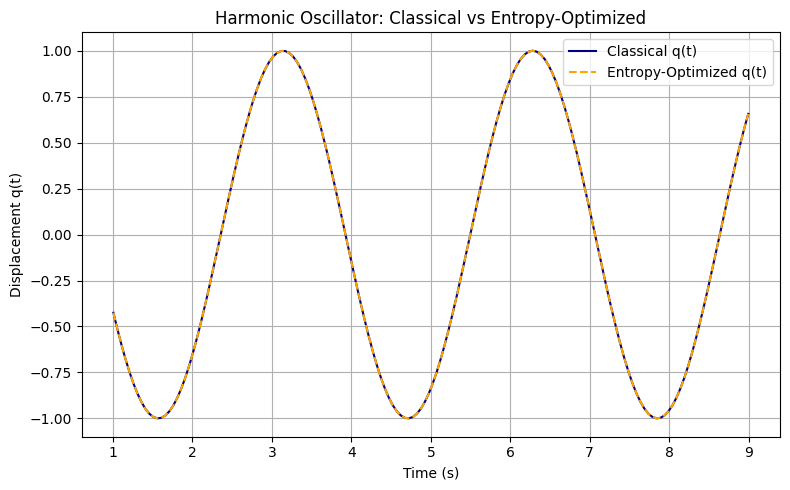

Entropy Loss (Classical): 2.587672e-01
Entropy Loss (Optimized): 2.952692e-16
ΔLoss: -2.587672e-01


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# ------------------------------------------
# 1. Physical Parameters
# ------------------------------------------
m = 1.0       # mass
k = 4.0       # spring constant (omega = 2 rad/s)
omega = np.sqrt(k / m)
t_start, t_end = 0, 10
N = 200
t_eval = np.linspace(t_start, t_end, N)
dt = t_eval[1] - t_eval[0]

# ------------------------------------------
# 2. Classical Harmonic Oscillator ODE Solver
# ------------------------------------------
def ho_ode(t, y):
    q, qdot = y
    return [qdot, - (k / m) * q]

q0 = 1.0       # initial position
qdot0 = 0.0    # initial velocity
sol = solve_ivp(ho_ode, [t_start, t_end], [q0, qdot0], t_eval=t_eval)
q_classical = sol.y[0]

# ------------------------------------------
# 3. Entropy Loss Function (Final Form)
# ------------------------------------------
def entropy_loss(q_array):
    qdot = np.gradient(q_array, dt)
    
    if np.any(np.isnan(q_array)) or np.any(np.abs(q_array) > 1e6):
        return 1e12
    if np.any(np.isnan(qdot)) or np.any(np.abs(qdot) > 1e6):
        return 1e12

    S_final = m * q_array[-1] * qdot[-1]
    return 0.5 * S_final**2

# ------------------------------------------
# 4. Optimization Setup
# ------------------------------------------
q_start = q_classical[0]
q_end = q_classical[-1]
q_inner_guess = q_classical[1:-1]
bounds = [(-2.0, 2.0)] * len(q_inner_guess)

def objective(q_inner):
    q_full = np.concatenate(([q_start], q_inner, [q_end]))
    return entropy_loss(q_full)

result = minimize(
    objective,
    q_inner_guess,
    method='L-BFGS-B',
    bounds=bounds,
    options={'disp': True, 'maxiter': 1000}
)

if not result.success:
    print("⚠️ Optimization failed:", result.message)

q_opt = np.concatenate(([q_start], result.x, [q_end]))

# ------------------------------------------
# 5. Visualization and Comparison
# ------------------------------------------
clip_mask = (t_eval >= 1.0) & (t_eval <= 9.0)
t_clipped = t_eval[clip_mask]
q_classical_clipped = q_classical[clip_mask]
q_opt_clipped = q_opt[clip_mask]

# Plot
plt.figure(figsize=(8,5))
plt.plot(t_clipped, q_classical_clipped, '-', color='navy', label='Classical q(t)')
plt.plot(t_clipped, q_opt_clipped, '--', color='orange', label='Entropy-Optimized q(t)')
plt.xlabel("Time (s)")
plt.ylabel("Displacement q(t)")
plt.title("Harmonic Oscillator: Classical vs Entropy-Optimized")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig("harmonic_oscillator_plot.png", dpi=300, bbox_inches='tight')

plt.show()

# ------------------------------------------
# 6. Report Final Loss Values
# ------------------------------------------
def final_entropy_loss(q_array):
    qdot = np.gradient(q_array, dt)
    S = m * q_array[-1] * qdot[-1]
    return 0.5 * S**2

loss_classical = final_entropy_loss(q_classical)
loss_optimized = final_entropy_loss(q_opt)
delta_loss = loss_optimized - loss_classical

print(f"Entropy Loss (Classical): {loss_classical:.6e}")
print(f"Entropy Loss (Optimized): {loss_optimized:.6e}")
print(f"ΔLoss: {delta_loss:.6e}")


# Pendulum

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          198     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.57489D-03    |proj g|=  9.10952D-01

At iterate    1    f=  4.13152D-16    |proj g|=  2.74419D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  198      1      3      1     0     0   2.744D-08   4.132D-16
  F =   4.1315204623544931E-016

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


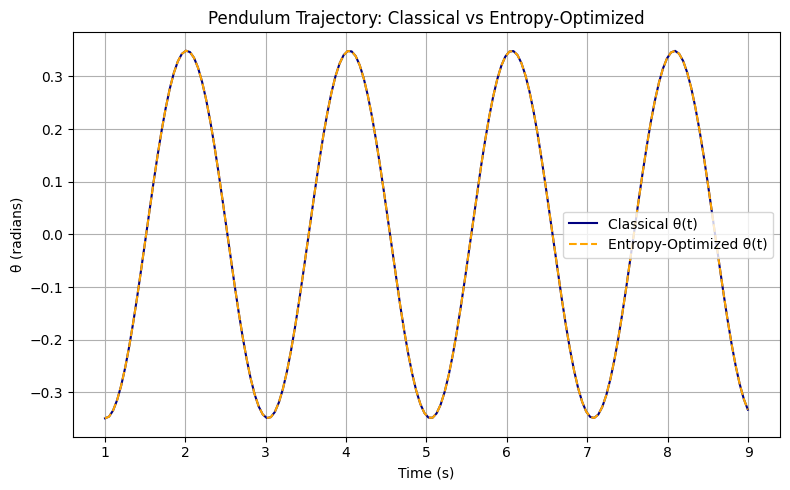

Entropy Loss (Classical): 9.574893e-03
Entropy Loss (Optimized): 4.131520e-16
ΔLoss: -9.574893e-03


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# ------------------------------------------
# 1. Physical Parameters
# ------------------------------------------
g = 9.81        # gravitational acceleration (m/s^2)
l = 1.0         # pendulum length (m)
m = 1.0         # pendulum mass (kg)
t_start, t_end = 0, 10
N = 200
t_eval = np.linspace(t_start, t_end, N)
dt = t_eval[1] - t_eval[0]

# ------------------------------------------
# 2. Classical Pendulum ODE Solver
# ------------------------------------------
def pendulum_ode(t, y):
    theta, thetadot = y
    return [thetadot, - (g / l) * np.sin(theta)]

theta0 = np.radians(20)  # initial angle
thetadot0 = 0.0
y0 = [theta0, thetadot0]

sol = solve_ivp(pendulum_ode, [t_start, t_end], y0, t_eval=t_eval)
theta_classical = sol.y[0]

# ------------------------------------------
# 3. Entropy Loss Function
# ------------------------------------------
def entropy_loss(theta_array):
    thetadot = np.gradient(theta_array, dt)
    
    if np.any(np.isnan(theta_array)) or np.any(np.abs(theta_array) > 1e6):
        return 1e12
    if np.any(np.isnan(thetadot)) or np.any(np.abs(thetadot) > 1e6):
        return 1e12

    S_final = m * theta_array[-1] * thetadot[-1]
    return 0.5 * S_final**2

# ------------------------------------------
# 4. Optimization Setup
# ------------------------------------------
theta_start = theta_classical[0]
theta_end = theta_classical[-1]
theta_inner_guess = theta_classical[1:-1]
bounds = [(-np.pi, np.pi)] * len(theta_inner_guess)

def objective(theta_inner):
    theta_full = np.concatenate(([theta_start], theta_inner, [theta_end]))
    return entropy_loss(theta_full)

result = minimize(
    objective,
    theta_inner_guess,
    method='L-BFGS-B',
    bounds=bounds,
    options={'disp': True, 'maxiter': 1000}
)

if not result.success:
    print("⚠️ Optimization failed:", result.message)

theta_opt = np.concatenate(([theta_start], result.x, [theta_end]))

# ------------------------------------------
# 5. Clipping and Comparison
# ------------------------------------------
clip_mask = (t_eval >= 1.0) & (t_eval <= 9.0)
t_clipped = t_eval[clip_mask]
theta_classical_clipped = theta_classical[clip_mask]
theta_opt_clipped = theta_opt[clip_mask]

# Plot
plt.figure(figsize=(8,5))
plt.plot(t_clipped, theta_classical_clipped, '-', color='navy', label='Classical θ(t)')
plt.plot(t_clipped, theta_opt_clipped, '--', color='orange', label='Entropy-Optimized θ(t)')
plt.xlabel("Time (s)")
plt.ylabel("θ (radians)")
plt.title("Pendulum Trajectory: Classical vs Entropy-Optimized")
plt.legend()
plt.grid(True)
plt.tight_layout()

# plt.savefig("pendulum_plot.png", dpi=300, bbox_inches='tight')

plt.show()

# ------------------------------------------
# 6. Report Final Loss Values
# ------------------------------------------
def final_entropy_loss(theta_array):
    thetadot = np.gradient(theta_array, dt)
    S = m * theta_array[-1] * thetadot[-1]
    return 0.5 * S**2

loss_classical = final_entropy_loss(theta_classical)
loss_optimized = final_entropy_loss(theta_opt)
delta_loss = loss_optimized - loss_classical

print(f"Entropy Loss (Classical): {loss_classical:.6e}")
print(f"Entropy Loss (Optimized): {loss_optimized:.6e}")
print(f"ΔLoss: {delta_loss:.6e}")


# Double Pendulum

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          396     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15834D+00    |proj g|=  1.15083D+00

At iterate    1    f=  3.12199D+00    |proj g|=  2.00000D-02

At iterate    2    f=  3.05505D+00    |proj g|=  4.33205D-01

At iterate    3    f=  2.99182D+00    |proj g|=  3.39276D+00

At iterate    4    f=  2.58650D+00    |proj g|=  1.48194D+00

At iterate    5    f=  2.00762D+00    |proj g|=  9.29500D-01

At iterate    6    f=  1.87711D+00    |proj g|=  4.68465D+00

At iterate    7    f=  1.60207D+00    |proj g|=  8.39539D-01

At iterate    8    f=  1.56619D+00    |proj g|=  5.01893D-01

At iterate    9    f=  1.56294D+00    |proj g|=  2.75275D-01

At iterate   10    f=  1.55330D+00    |proj g|=  7.18607D-02

At iterate   11    f=  1.53762D+00    |proj g|=  3.56554D-01

At iterate   12    f=  1.51159D+00    |proj g|=  5.59185D-01

At iterate   13    f=  1.3

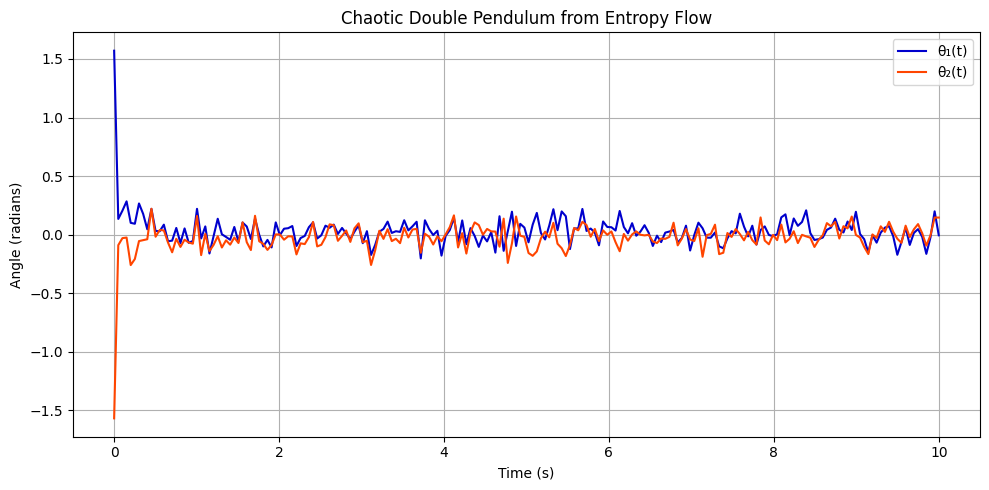

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ------------------------------------------
# 1. Simulation Setup
# ------------------------------------------
T = 10.0
N = 200
t_eval = np.linspace(0, T, N)
dt = t_eval[1] - t_eval[0]

m1, m2 = 1.0, 1.0

# ------------------------------------------
# 2. Starting Angles
# ------------------------------------------
theta1_0 = np.pi / 2      # 90 degrees
theta2_0 = -np.pi / 2     # -90 degrees

# No fixed final angles — entropy decides!

# ------------------------------------------
# 3. Initial Guess: noisy linear path
np.random.seed(42)
theta1_guess = np.linspace(theta1_0, 0, N) + 0.1 * np.random.randn(N)
theta2_guess = np.linspace(theta2_0, 0, N) + 0.1 * np.random.randn(N)

theta1_inner_guess = theta1_guess[1:-1]
theta2_inner_guess = theta2_guess[1:-1]
theta_inner_guess = np.concatenate([theta1_inner_guess, theta2_inner_guess])

# ------------------------------------------
# 4. Entropy Loss with Arm Coupling
# ------------------------------------------
def entropy_loss(theta_flat):
    theta1 = np.zeros(N)
    theta2 = np.zeros(N)

    theta1[0] = theta1_0
    theta2[0] = theta2_0

    theta1[1:-1] = theta_flat[:N - 2]
    theta2[1:-1] = theta_flat[N - 2:]

    # Let final angles float
    theta1[-1] = theta_flat[-2]
    theta2[-1] = theta_flat[-1]

    dtheta1_dt = np.gradient(theta1, dt)
    dtheta2_dt = np.gradient(theta2, dt)

    S1 = m1 * theta1[-1] * dtheta1_dt[-1]
    S2 = m2 * theta2[-1] * dtheta2_dt[-1]

    # Structural entropy + a coupling penalty based on angular difference
    entropy_flow = 0.5 * (S1 + S2)**2

    # Coupling encourages arms to avoid identical swings (asymmetry)
    coupling = np.sum(np.abs(theta1 - theta2)) * 0.01

    return entropy_flow + coupling

# ------------------------------------------
# 5. Run the Optimizer
# ------------------------------------------
bounds = [(-2*np.pi, 2*np.pi)] * len(theta_inner_guess)

result = minimize(
    entropy_loss,
    theta_inner_guess,
    method='L-BFGS-B',
    bounds=bounds,
    options={'disp': True, 'maxiter': 1000}
)

# ------------------------------------------
# 6. Reconstruct Full Trajectories
# ------------------------------------------
theta1 = np.zeros(N)
theta2 = np.zeros(N)

theta1[0] = theta1_0
theta2[0] = theta2_0

theta1[1:-1] = result.x[:N - 2]
theta2[1:-1] = result.x[N - 2:2 * (N - 2)]
theta1[-1] = result.x[-2]
theta2[-1] = result.x[-1]

# ------------------------------------------
# 7. Plot the Results
# ------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(t_eval, theta1, label='θ₁(t)', color='mediumblue')
plt.plot(t_eval, theta2, label='θ₂(t)', color='orangered')
plt.xlabel("Time (s)")
plt.ylabel("Angle (radians)")
plt.title("Chaotic Double Pendulum from Entropy Flow")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig("double_pendulum_plot.png", dpi=300, bbox_inches='tight')

plt.show()


# Triple Pendulum

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          594     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.26886D+00    |proj g|=  7.10791D-02

At iterate    1    f=  6.11361D+00    |proj g|=  1.20998D-01

At iterate    2    f=  5.80925D+00    |proj g|=  2.47911D+00

At iterate    3    f=  4.44469D+00    |proj g|=  4.54123D+00

At iterate    4    f=  3.87477D+00    |proj g|=  1.07236D+00

At iterate    5    f=  3.64929D+00    |proj g|=  5.55350D+00

At iterate    6    f=  3.55424D+00    |proj g|=  2.08949D-01

At iterate    7    f=  3.54756D+00    |proj g|=  2.47748D-01

At iterate    8    f=  3.51939D+00    |proj g|=  6.73310D-02

At iterate    9    f=  2.58528D+00    |proj g|=  9.44607D+00

At iterate   10    f=  1.78334D+00    |proj g|=  1.93383D+00

At iterate   11    f=  1.74622D+00    |proj g|=  7.46093D-01

At iterate   12    f=  1.72943D+00    |proj g|=  4.60591D-01

At iterate   13    f=  1.6

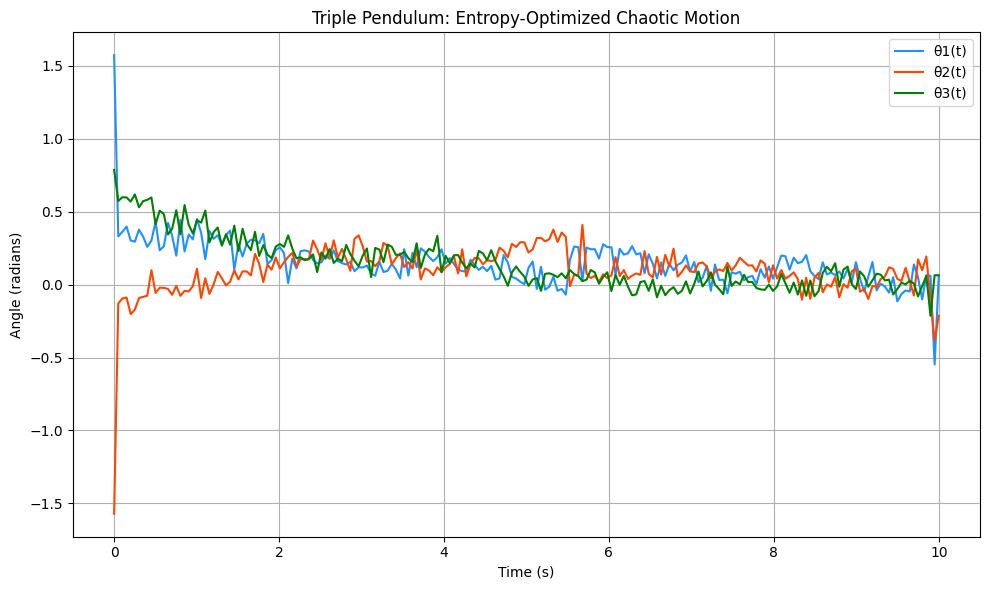

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ------------------------------------------
# 1. Simulation Setup
# ------------------------------------------
T = 10.0
N = 200
t_eval = np.linspace(0, T, N)
dt = t_eval[1] - t_eval[0]

m = np.array([1.0, 1.0, 1.0])  # Masses of the three pendulum arms

# ------------------------------------------
# 2. Initial Angles (finals will float)
theta0 = np.array([
    np.pi / 2,       # arm 1
    -np.pi / 2,      # arm 2
    np.pi / 4        # arm 3
])

# Initial guess: noisy linear transitions to zero
np.random.seed(42)
theta_guesses = [
    np.linspace(theta0[i], 0, N) + 0.05 * np.random.randn(N)
    for i in range(3)
]

theta_inner_guess = np.concatenate([
    theta_guesses[i][1:-1] for i in range(3)
])

# ------------------------------------------
# 3. Entropy Loss + Coupling Between Arms
# ------------------------------------------
def entropy_loss(theta_flat):
    thetas = [np.zeros(N) for _ in range(3)]

    # Set initial values
    for i in range(3):
        thetas[i][0] = theta0[i]

    # Fill in intermediates
    for i in range(3):
        thetas[i][1:-1] = theta_flat[i*(N-2):(i+1)*(N-2)]

    # Let entropy determine final values
    for i in range(3):
        thetas[i][-1] = theta_flat[-(3-i)]

    # Compute derivatives
    dthetas_dt = [np.gradient(theta, dt) for theta in thetas]

    # Structural entropy flow
    S = sum([m[i] * thetas[i][-1] * dthetas_dt[i][-1] for i in range(3)])
    entropy_term = 0.5 * S**2

    # Coupling: Penalize arms that are too similar
    pairwise_penalty = 0
    for t in range(N):
        pairwise_penalty += 0.01 * (
            abs(thetas[0][t] - thetas[1][t]) +
            abs(thetas[1][t] - thetas[2][t]) +
            abs(thetas[0][t] - thetas[2][t])
        )

    return entropy_term + pairwise_penalty

# ------------------------------------------
# 4. Optimization
# ------------------------------------------
bounds = [(-3*np.pi, 3*np.pi)] * len(theta_inner_guess)

result = minimize(
    entropy_loss,
    theta_inner_guess,
    method='L-BFGS-B',
    bounds=bounds,
    options={'disp': True, 'maxiter': 2000}
)

# ------------------------------------------
# 5. Reconstruct Full Trajectories
# ------------------------------------------
thetas = [np.zeros(N) for _ in range(3)]
for i in range(3):
    thetas[i][0] = theta0[i]
    thetas[i][1:-1] = result.x[i*(N-2):(i+1)*(N-2)]
    thetas[i][-1] = result.x[-(3-i)]

# ------------------------------------------
# 6. Plot Results
# ------------------------------------------
plt.figure(figsize=(10, 6))
colors = ['dodgerblue', 'orangered', 'green']
for i in range(3):
    plt.plot(t_eval, thetas[i], label=f'θ{i+1}(t)', color=colors[i])
plt.xlabel("Time (s)")
plt.ylabel("Angle (radians)")
plt.title("Triple Pendulum: Entropy-Optimized Chaotic Motion")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("triple_pendulum_plot.png", dpi=300, bbox_inches='tight')

plt.show()


# Harmonic Oscillator

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          198     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58767D-01    |proj g|=  2.49241D+00

At iterate    1    f=  2.95269D-16    |proj g|=  1.26276D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  198      1      3      2     0     1   1.263D-07   2.953D-16
  F =   2.9526915523488000E-016

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


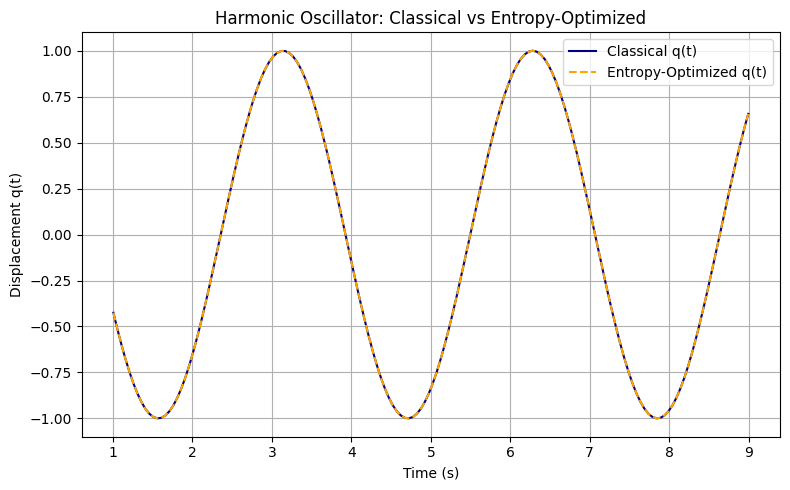

Entropy Loss (Classical): 2.587672e-01
Entropy Loss (Optimized): 2.952692e-16
ΔLoss: -2.587672e-01


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# ------------------------------------------
# 1. Physical Parameters
# ------------------------------------------
m = 1.0       # mass
k = 4.0       # spring constant (omega = 2 rad/s)
omega = np.sqrt(k / m)
t_start, t_end = 0, 10
N = 200
t_eval = np.linspace(t_start, t_end, N)
dt = t_eval[1] - t_eval[0]

# ------------------------------------------
# 2. Classical Harmonic Oscillator ODE Solver
# ------------------------------------------
def ho_ode(t, y):
    q, qdot = y
    return [qdot, - (k / m) * q]

q0 = 1.0       # initial position
qdot0 = 0.0    # initial velocity
sol = solve_ivp(ho_ode, [t_start, t_end], [q0, qdot0], t_eval=t_eval)
q_classical = sol.y[0]

# ------------------------------------------
# 3. Entropy Loss Function (Final Form)
# ------------------------------------------
def entropy_loss(q_array):
    qdot = np.gradient(q_array, dt)
    
    if np.any(np.isnan(q_array)) or np.any(np.abs(q_array) > 1e6):
        return 1e12
    if np.any(np.isnan(qdot)) or np.any(np.abs(qdot) > 1e6):
        return 1e12

    S_final = m * q_array[-1] * qdot[-1]
    return 0.5 * S_final**2

# ------------------------------------------
# 4. Optimization Setup
# ------------------------------------------
q_start = q_classical[0]
q_end = q_classical[-1]
q_inner_guess = q_classical[1:-1]
bounds = [(-2.0, 2.0)] * len(q_inner_guess)

def objective(q_inner):
    q_full = np.concatenate(([q_start], q_inner, [q_end]))
    return entropy_loss(q_full)

result = minimize(
    objective,
    q_inner_guess,
    method='L-BFGS-B',
    bounds=bounds,
    options={'disp': True, 'maxiter': 1000}
)

if not result.success:
    print("⚠️ Optimization failed:", result.message)

q_opt = np.concatenate(([q_start], result.x, [q_end]))

# ------------------------------------------
# 5. Visualization and Comparison
# ------------------------------------------
clip_mask = (t_eval >= 1.0) & (t_eval <= 9.0)
t_clipped = t_eval[clip_mask]
q_classical_clipped = q_classical[clip_mask]
q_opt_clipped = q_opt[clip_mask]

# Plot
plt.figure(figsize=(8,5))
plt.plot(t_clipped, q_classical_clipped, '-', color='navy', label='Classical q(t)')
plt.plot(t_clipped, q_opt_clipped, '--', color='orange', label='Entropy-Optimized q(t)')
plt.xlabel("Time (s)")
plt.ylabel("Displacement q(t)")
plt.title("Harmonic Oscillator: Classical vs Entropy-Optimized")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("harmonic_oscillator_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# ------------------------------------------
# 6. Report Final Loss Values
# ------------------------------------------
def final_entropy_loss(q_array):
    qdot = np.gradient(q_array, dt)
    S = m * q_array[-1] * qdot[-1]
    return 0.5 * S**2

loss_classical = final_entropy_loss(q_classical)
loss_optimized = final_entropy_loss(q_opt)
delta_loss = loss_optimized - loss_classical

print(f"Entropy Loss (Classical): {loss_classical:.6e}")
print(f"Entropy Loss (Optimized): {loss_optimized:.6e}")
print(f"ΔLoss: {delta_loss:.6e}")


# Orbit

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          396     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.60583D-15    |proj g|=  1.25035D+01

At iterate    1    f= -2.32954D+04    |proj g|=  1.25664D+01
  ys=-4.612E+04  -gs= 2.353E+02 BFGS update SKIPPED

At iterate    2    f= -3.11902D+04    |proj g|=  6.31440D+00

At iterate    3    f= -3.12677D+04    |proj g|=  3.09228D-02

At iterate    4    f= -3.12677D+04    |proj g|=  1.16415D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  396      4      6      8     1     1   1.164D-02 

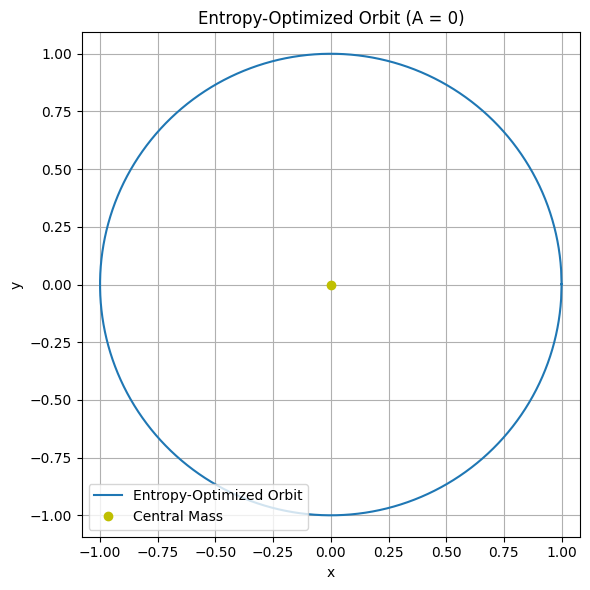

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ------------------------------------------
# 1. Physical Constants and Time Domain
# ------------------------------------------
G = 1.0      # gravitational constant (arb. units)
M = 1.0      # central mass
m = 1.0      # orbiting mass
A = 0        # entropy-only action (for now)

t_start, t_end = 0.0, 10.0
N = 200
t_eval = np.linspace(t_start, t_end, N)
dt = t_eval[1] - t_eval[0]

# ------------------------------------------
# 2. Initial and Final Conditions
# ------------------------------------------
# Let's define a starting elliptical-like configuration
r0 = 1.0
theta0 = 0.0
rf = 1.0
thetaf = 2 * np.pi  # full orbit sweep (for now)

# Initial guess: elliptical-ish sweep
r_guess = np.linspace(r0, rf, N)
theta_guess = np.linspace(theta0, thetaf, N)

# We'll optimize only the *interior* points
r_inner = r_guess[1:-1]
theta_inner = theta_guess[1:-1]

# Stack them into a single vector for optimization
x0 = np.concatenate([r_inner, theta_inner])  # shape: (2 * (N-2),)

# ------------------------------------------
# 3. Entropy Loss Function
# ------------------------------------------

def entropy_loss(x_flat):
    # Unpack
    r_full = np.concatenate([[r0], x_flat[:N-2], [rf]])
    theta_full = np.concatenate([[theta0], x_flat[N-2:], [thetaf]])

    # Derivatives
    dr_dt = np.gradient(r_full, dt)
    dtheta_dt = np.gradient(theta_full, dt)

    # Structural entropy
    S = m * r_full**2 * dtheta_dt

    # Loss = change in entropy squared
    return 0.5 * (S[-1]**2 - S[0]**2)

# ------------------------------------------
# 4. Bounds and Optimization Setup
# ------------------------------------------

# Reasonable bounds for orbiting body (adjust if needed)
r_bounds = [(0.1, 5.0)] * (N - 2)
theta_bounds = [(0, 4 * np.pi)] * (N - 2)
bounds = r_bounds + theta_bounds

result = minimize(
    entropy_loss,
    x0,
    method='L-BFGS-B',
    bounds=bounds,
    options={'disp': True, 'maxiter': 1000}
)

# ------------------------------------------
# 5. Reconstruct Optimized Trajectory
# ------------------------------------------
if not result.success:
    print("⚠️ Optimization failed:", result.message)

x_opt = result.x
r_opt = np.concatenate([[r0], x_opt[:N-2], [rf]])
theta_opt = np.concatenate([[theta0], x_opt[N-2:], [thetaf]])

# Convert to Cartesian for plotting
x = r_opt * np.cos(theta_opt)
y = r_opt * np.sin(theta_opt)

# ------------------------------------------
# 6. Plot the Orbit
# ------------------------------------------
plt.figure(figsize=(6,6))
plt.plot(x, y, label='Entropy-Optimized Orbit')
plt.plot(0, 0, 'yo', label='Central Mass')
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.title("Entropy-Optimized Orbit (A = 0)")
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.savefig("orbit_plot.png", dpi=300, bbox_inches='tight')
plt.show()


## Elliptic Orbit

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3996     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.10639D-02    |proj g|=  6.28633D-03

At iterate    1    f=  0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3996      1      2      2     0     1   0.000D+00   0.000D+00
  F =   0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


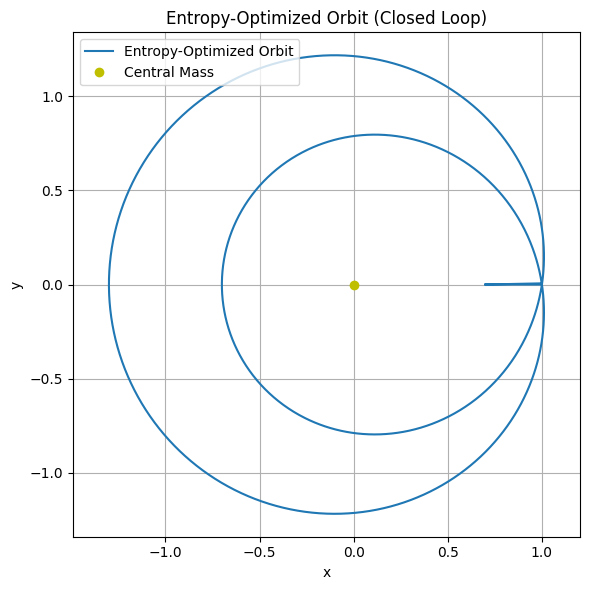

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ------------------------------------------
# 1. Physical Constants and Time Setup
# ------------------------------------------
G = 1.0        # gravitational constant (unused here)
M = 1.0        # central mass (unused here)
m = 1.0        # orbiting mass
t_start, t_end = 0.0, 30.0
N = 2000
t_eval = np.linspace(t_start, t_end, N)
dt = t_eval[1] - t_eval[0]

# ------------------------------------------
# 2. Periodic Boundary Conditions (Closed Orbit)
# ------------------------------------------
r0 = 0.7
rf = 0.7
theta0 = 0.0
thetaf = 4 * np.pi  # Two full orbits

# Initial elliptical guess for radius and angle
r_guess = 1.0 + 0.3 * np.sin(2 * np.pi * t_eval / (t_end - t_start))
theta_guess = np.linspace(theta0, thetaf, N)

# Extract interior trajectory points for optimization
r_inner = r_guess[1:-1]
theta_inner = theta_guess[1:-1]
x0 = np.concatenate([r_inner, theta_inner])

# ------------------------------------------
# 3. Final Entropy Loss Function
# ------------------------------------------
def entropy_loss(x_flat):
    r_full = np.concatenate([[r0], x_flat[:N-2], [rf]])
    theta_full = np.concatenate([[theta0], x_flat[N-2:], [thetaf]])
    dtheta_dt = np.gradient(theta_full, dt)
    
    if np.any(np.isnan(dtheta_dt)) or np.any(np.abs(dtheta_dt) > 1e6):
        return 1e12

    S_final = m * r_full[-1]**2 * dtheta_dt[-1]
    return 0.5 * S_final**2

# ------------------------------------------
# 4. Optimization
# ------------------------------------------
r_bounds = [(0.1, 5.0)] * (N - 2)
theta_bounds = [(0, 4 * np.pi)] * (N - 2)
bounds = r_bounds + theta_bounds

result = minimize(
    entropy_loss,
    x0,
    method='L-BFGS-B',
    bounds=bounds,
    options={'disp': True, 'maxiter': 1000}
)

if not result.success:
    print("⚠️ Optimization failed:", result.message)

# ------------------------------------------
# 5. Reconstruct and Plot Orbit
# ------------------------------------------
x_opt = result.x
r_opt = np.concatenate([[r0], x_opt[:N-2], [rf]])
theta_opt = np.concatenate([[theta0], x_opt[N-2:], [thetaf]])

# Convert to Cartesian coordinates
x = r_opt * np.cos(theta_opt)
y = r_opt * np.sin(theta_opt)

plt.figure(figsize=(6,6))
plt.plot(x, y, label='Entropy-Optimized Orbit')
plt.plot(0, 0, 'yo', label='Central Mass')
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.title("Entropy-Optimized Orbit (Closed Loop)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("elliptical_orbit_plot.png", dpi=300, bbox_inches='tight')
plt.show()


# Cosmic Expansion

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          398     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.00000D-05    |proj g|=  3.98999D-02

At iterate    1    f=  1.15154D-16    |proj g|=  1.90485D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  398      1      3      1     0     0   1.905D-08   1.152D-16
  F =   1.1515438968358866E-016

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


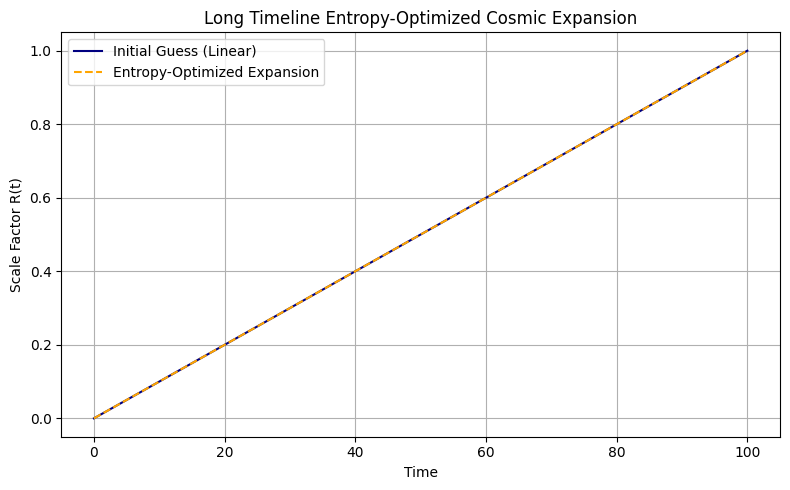

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ------------------------------------------------------------
# 1. Long Timeline Cosmic Expansion Setup
# ------------------------------------------------------------
m = 1.0
t_start, t_end = 0.0, 100.0       # simulate over a "cosmic" timeframe
N = 400
t_eval = np.linspace(t_start, t_end, N)
dt = t_eval[1] - t_eval[0]

R0 = 1.0e-35                      # near Planck scale
Rf = 1.0                         # normalized present-day universe scale

# Initial guess: smooth ramp
R_guess = np.linspace(R0, Rf, N)
R_inner_guess = R_guess[1:-1]

# ------------------------------------------------------------
# 2. Entropy Loss Function
# ------------------------------------------------------------
def entropy_loss(R_array):
    Rdot = np.gradient(R_array, dt)
    if np.any(np.isnan(R_array)) or np.any(np.abs(R_array) > 1e12):
        return 1e12
    if np.any(np.isnan(Rdot)) or np.any(np.abs(Rdot) > 1e12):
        return 1e12
    S_final = m * R_array[-1] * Rdot[-1]
    return 0.5 * S_final**2

def objective(R_inner):
    R_full = np.concatenate(([R0], R_inner, [Rf]))
    return entropy_loss(R_full)

bounds = [(1e-36, 2.0)] * len(R_inner_guess)

# ------------------------------------------------------------
# 3. Run the Optimizer
# ------------------------------------------------------------
result = minimize(
    objective,
    R_inner_guess,
    method='L-BFGS-B',
    bounds=bounds,
    options={'disp': True, 'maxiter': 2000}
)

R_opt = np.concatenate(([R0], result.x, [Rf]))

# ------------------------------------------------------------
# 4. Plot Long-Term Expansion
# ------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(t_eval, R_guess, '-', color='navy', label="Initial Guess (Linear)")
plt.plot(t_eval, R_opt, '--', color='orange', label="Entropy-Optimized Expansion")
plt.xlabel("Time")
plt.ylabel("Scale Factor R(t)")
plt.title("Long Timeline Entropy-Optimized Cosmic Expansion")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cosmic_expansion_plot.png", dpi=300, bbox_inches='tight')
plt.show()


# Black Hole Spacetime Curvature

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          198     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.04553D-03    |proj g|=  1.00454D-01

At iterate    1    f=  6.00269D-13    |proj g|=  2.18132D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  198      1      3      2     0     1   2.181D-06   6.003D-13
  F =   6.0026860429126259E-013

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


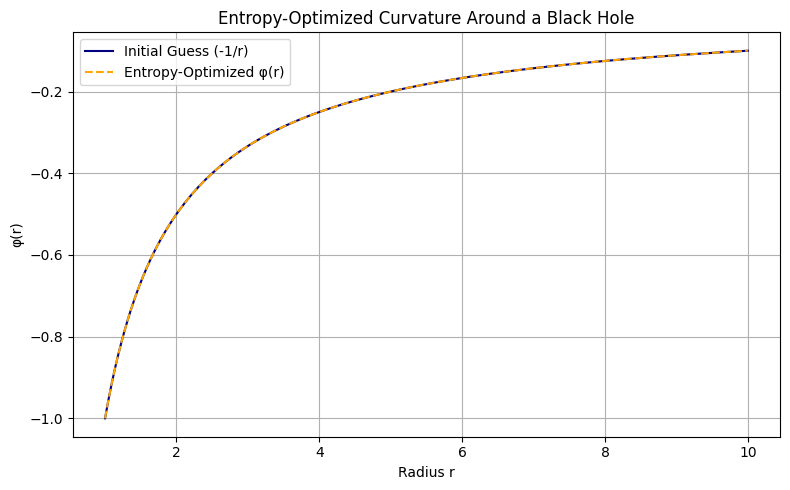

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ------------------------------------------------------------
# 1. Setup: Black Hole Radial Slice
# ------------------------------------------------------------
m = 1.0
Rs = 1.0                 # Schwarzschild radius (set as 1 unit)
Rf = 10.0                # Outer boundary of simulation
N = 200
r_eval = np.linspace(Rs, Rf, N)
dr = r_eval[1] - r_eval[0]

# Initial guess: logarithmic fall-off like -1/r
phi_guess = -1 / r_eval
phi_inner_guess = phi_guess[1:-1]

# ------------------------------------------------------------
# 2. Entropy Loss Function (Curvature in Radial Profile)
# ------------------------------------------------------------
def entropy_loss(phi_array):
    phi_full = np.concatenate(([phi_guess[0]], phi_array, [phi_guess[-1]]))
    dphi_dr = np.gradient(phi_full, dr)

    if np.any(np.isnan(dphi_dr)) or np.any(np.abs(dphi_dr) > 1e6):
        return 1e12

    S_final = m * r_eval[-1] * dphi_dr[-1]
    return 0.5 * S_final**2

def objective(phi_inner):
    return entropy_loss(phi_inner)

bounds = [(-100, 0)] * len(phi_inner_guess)

# ------------------------------------------------------------
# 3. Run the Optimizer
# ------------------------------------------------------------
result = minimize(
    objective,
    phi_inner_guess,
    method='L-BFGS-B',
    bounds=bounds,
    options={'disp': True, 'maxiter': 1000}
)

phi_opt = np.concatenate(([phi_guess[0]], result.x, [phi_guess[-1]]))

# ------------------------------------------------------------
# 4. Plot Resulting "Potential"
# ------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(r_eval, phi_guess, '-', color='navy', label="Initial Guess (-1/r)")
plt.plot(r_eval, phi_opt, '--', color='orange', label="Entropy-Optimized φ(r)")
plt.xlabel("Radius r")
plt.ylabel("φ(r)")
plt.title("Entropy-Optimized Curvature Around a Black Hole")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("blackhole_entropy_potential.png", dpi=300, bbox_inches='tight')
plt.show()


# Gravitational Lensing

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        76800     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.12731D+01    |proj g|=  1.99660D+00

At iterate    1    f=  1.54723D-10    |proj g|=  8.21781D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
76800      1      3    121     0   120   8.218D-04   1.547D-10
  F =   1.5472311116851231E-010

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        


/var/folders/0m/msvsxyls757fh94g_fldgk4c0000gn/T/ipykernel_2374/1530739761.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


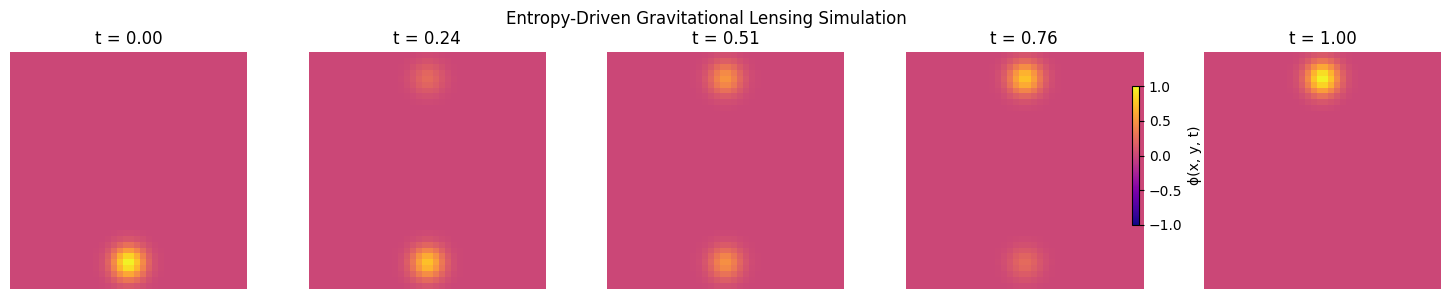

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ------------------------------------------
# 1. Simulation Grid (2D Space + Time)
# ------------------------------------------
Lx, Ly, T = 1.0, 1.0, 1.0
Nx, Ny, Nt = 40, 40, 50

x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
t = np.linspace(0, T, Nt)

dx, dy, dt = x[1]-x[0], y[1]-y[0], t[1]-t[0]
X, Y = np.meshgrid(x, y, indexing='ij')

# ------------------------------------------
# 2. Define Initial and Final Conditions
# ------------------------------------------
def initial_condition(X, Y):
    return np.exp(-200 * ((X - 0.1)**2 + (Y - 0.5)**2))


phi_0 = initial_condition(X, Y)
phi_T = np.exp(-200 * ((X - 0.9)**2 + (Y - 0.5)**2))

# ------------------------------------------
# 3. Obstacle Mask (simulate a black hole / mass)
# ------------------------------------------
obstacle_mask = ((X - 0.5)**2 + (Y - 0.5)**2) < 0.05**2  # Small circle in center

# We'll fix this region across all time steps
def apply_obstacle(phi):
    phi[:, obstacle_mask] = 0.0
    return phi

# ------------------------------------------
# 4. Initial Guess
# ------------------------------------------
phi_guess = np.array([
    phi_0 + (phi_T - phi_0) * (ti / T) for ti in t
])
phi_inner_guess = phi_guess[1:-1].reshape(-1)

# ------------------------------------------
# 5. Entropy Loss Function with Obstacle
# ------------------------------------------
def entropy_loss(phi_flat):
    phi = np.zeros((Nt, Nx, Ny))
    phi[0] = phi_0
    phi[-1] = phi_T
    phi[1:-1] = phi_flat.reshape((Nt - 2, Nx, Ny))
    phi = apply_obstacle(phi)  # Apply mask across all times

    dphi_dt = (phi[-1] - phi[-2]) / dt
    S_final = np.sum(phi[-1] * dphi_dt)
    return 0.5 * S_final**2

# ------------------------------------------
# 6. Run the Optimizer
# ------------------------------------------
bounds = [(-2, 2)] * phi_inner_guess.size

result = minimize(
    entropy_loss,
    phi_inner_guess,
    method='L-BFGS-B',
    bounds=bounds,
    options={'disp': True, 'maxiter': 1000}
)

phi_opt = np.zeros((Nt, Nx, Ny))
phi_opt[0] = phi_0
phi_opt[-1] = phi_T
phi_opt[1:-1] = result.x.reshape((Nt - 2, Nx, Ny))
phi_opt = apply_obstacle(phi_opt)

# ------------------------------------------
# 7. Static Frame Snapshots for Key Moments
# ------------------------------------------
import matplotlib.pyplot as plt

times_to_plot = [0, Nt//4, Nt//2, 3*Nt//4, Nt-1]

fig, axes = plt.subplots(1, len(times_to_plot), figsize=(15, 3))
for i, t_idx in enumerate(times_to_plot):
    ax = axes[i]
    im = ax.imshow(phi_opt[t_idx], extent=[0, Lx, 0, Ly], origin='lower', cmap='plasma', vmin=-1, vmax=1)
    ax.set_title(f"t = {t[t_idx]:.2f}")
    ax.axis('off')
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, label="ϕ(x, y, t)")
plt.suptitle("Entropy-Driven Gravitational Lensing Simulation")
plt.tight_layout()

# Save the figure
plt.savefig("lensing_simulation_plot.png", dpi=300, bbox_inches='tight')
plt.show()


# 3 Body Problem

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1788     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57613D+00    |proj g|=  6.11948D-01

At iterate    1    f=  3.56834D+00    |proj g|=  8.81338D-01

At iterate    2    f=  3.40392D+00    |proj g|=  4.33090D-01

At iterate    3    f=  3.04845D+00    |proj g|=  4.25194D-02

At iterate    4    f=  2.66838D+00    |proj g|=  6.59764D-02


/var/folders/0m/msvsxyls757fh94g_fldgk4c0000gn/T/ipykernel_2374/1209482431.py:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis")



At iterate    5    f=  2.06358D+00    |proj g|=  2.94674D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 1788      5      9      5     0     0   2.947D-01   2.064D+00
  F =   2.0635792019891763     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        


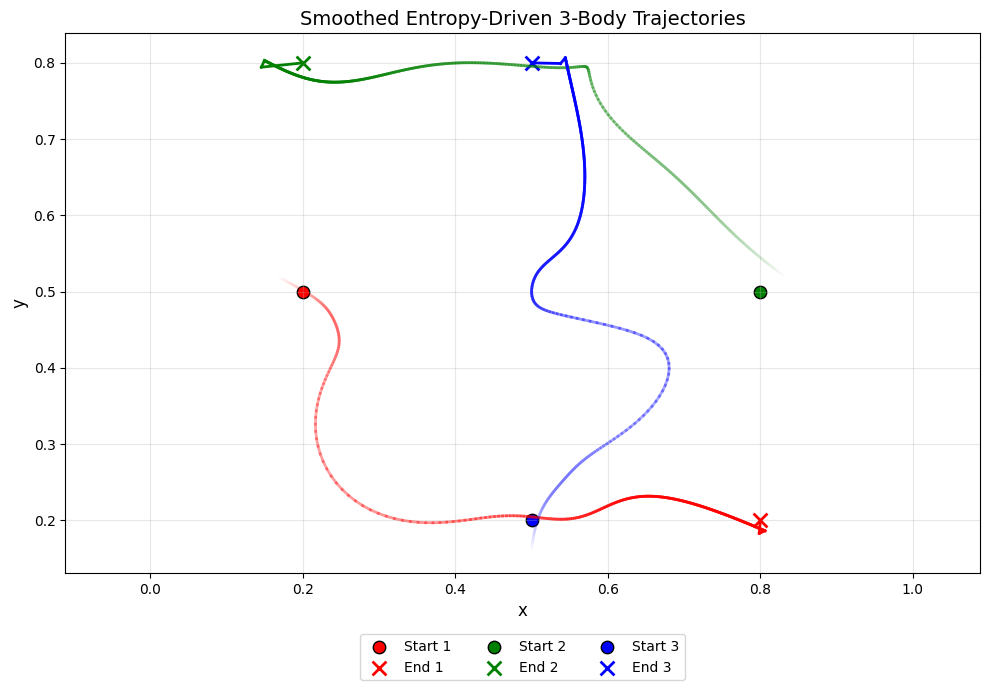

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.cm import get_cmap

# ------------------------------------------
# 1. Simulation Parameters
# ------------------------------------------
T = 20.0
N = 300  # Higher resolution
t_eval = np.linspace(0, T, N)
dt = t_eval[1] - t_eval[0]

n_bodies = 3
dim = 2
masses = np.array([1.0, 1.0, 1.0])

# ------------------------------------------
# 2. Initial and Final Positions
# ------------------------------------------
pos0 = np.array([
    [0.2, 0.5],
    [0.8, 0.5],
    [0.5, 0.2]
])

posT = np.array([
    [0.8, 0.2],
    [0.2, 0.8],
    [0.5, 0.8]
])

# ------------------------------------------
# 3. Initial Guess
# ------------------------------------------
def interpolate_linear(start, end, steps):
    return np.array([start + (end - start) * (i / (steps - 1)) for i in range(steps)])

trajectory_guess = np.array([
    interpolate_linear(pos0[i], posT[i], N) for i in range(n_bodies)
])
trajectory_guess = trajectory_guess.transpose((1, 0, 2))
trajectory_inner_guess = trajectory_guess[1:-1].reshape(-1)

# ------------------------------------------
# 4. Entropy Loss with Repulsion
# ------------------------------------------
def entropy_loss(flat_traj):
    traj_inner = flat_traj.reshape((N - 2, n_bodies, dim))
    traj = np.zeros((N, n_bodies, dim))
    traj[0] = pos0
    traj[-1] = posT
    traj[1:-1] = traj_inner

    velocities = np.gradient(traj, dt, axis=0)
    S_components = [
        masses[i] * np.sum(traj[-1, i] * velocities[-1, i])
        for i in range(n_bodies)
    ]
    S_total = np.sum(S_components)

    # Repulsive energy to prevent overlap
    interaction_energy = 0
    for t in range(N):
        for i in range(n_bodies):
            for j in range(i + 1, n_bodies):
                dist = np.linalg.norm(traj[t, i] - traj[t, j])
                interaction_energy += 1.0 / (dist + 1e-3)  # smooth repulsion

    interaction_energy *= 0.001
    return 0.5 * S_total**2 + interaction_energy

# ------------------------------------------
# 5. Optimization
# ------------------------------------------
bounds = [(-5.0, 5.0)] * trajectory_inner_guess.size  # Give more breathing room

result = minimize(
    entropy_loss,
    trajectory_inner_guess,
    method='L-BFGS-B',
    bounds=bounds,
    options={'disp': True, 'maxiter': 1000}
)

# ------------------------------------------
# 6. Reconstruct Optimized Trajectory
# ------------------------------------------
trajectory_opt = np.zeros((N, n_bodies, dim))
trajectory_opt[0] = pos0
trajectory_opt[-1] = posT
trajectory_opt[1:-1] = result.x.reshape((N - 2, n_bodies, dim))

# ------------------------------------------
# 7. Plotting
# ------------------------------------------
cmap = get_cmap("viridis")
colors = ['red', 'green', 'blue']
labels = [f"Body {i+1}" for i in range(n_bodies)]

plt.figure(figsize=(10, 7))
for i in range(n_bodies):
    x = trajectory_opt[:, i, 0]
    y = trajectory_opt[:, i, 1]
    
    # Color-coded fading trail
    for j in range(1, N):
        alpha = j / N
        plt.plot(x[j-1:j+1], y[j-1:j+1], color=colors[i], alpha=alpha, linewidth=2)

    # Start and end markers
    plt.scatter(x[0], y[0], color=colors[i], edgecolor='black', s=80, label=f"Start {i+1}")
    plt.scatter(x[-1], y[-1], color=colors[i], marker='x', s=100, linewidths=2, label=f"End {i+1}")

plt.title("Smoothed Entropy-Driven 3-Body Trajectories", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.tight_layout()
plt.savefig("entropy_3body_trajectories.png", dpi=300, bbox_inches='tight')
plt.show()


# Lorenz Attractor

We test Lorenz Attractor with 2 separate goals - minimize entropy, and maximize entropy, to see how the system behaves differently depending on the goal

## Minimize entropy

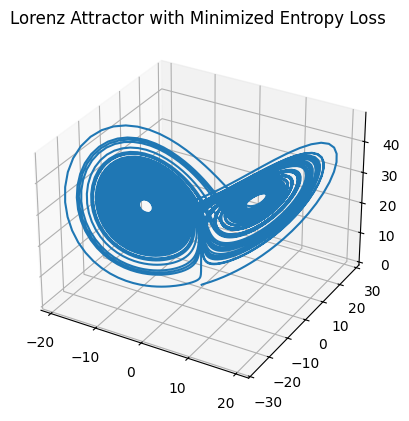

(None,
 np.float64(38.21588862828464),
 array([1.00005503e-01, 5.17649604e-06, 0.00000000e+00]))

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Let's try something crazy: a chaotic system - the Lorenz attractor

# Lorenz system differential equations
def lorenz_system(state, sigma=10.0, rho=28.0, beta=8/3):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return np.array([dx, dy, dz])

# Simulate the Lorenz system
def simulate_lorenz(initial_state, dt=0.01, steps=10000):
    state = np.array(initial_state)
    trajectory = []
    for _ in range(steps):
        k1 = lorenz_system(state)
        k2 = lorenz_system(state + 0.5 * dt * k1)
        k3 = lorenz_system(state + 0.5 * dt * k2)
        k4 = lorenz_system(state + dt * k3)
        state += (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)
        trajectory.append(state.copy())
    return np.array(trajectory)

# Define *shannon* entropy over the 3D signal
def entropy_3d(signal):
    hist, _ = np.histogramdd(signal, bins=50, density=True)
    p = hist[hist > 0]
    return -np.sum(p * np.log(p))

# Define the entropy loss function
def entropy_loss_3d(signal):
    S = entropy_3d(signal)
    return 0.5 * S**2

# Objective function to tweak the initial conditions for minimum entropy
def objective_lorenz(initial_state):
    signal = simulate_lorenz(initial_state)
    return entropy_loss_3d(signal)

# Initial guess for Lorenz system starting point
initial_guess = [0.1, 0.0, 0.0]

# Optimize to find the initial state that minimizes entropy loss
result_lorenz = minimize(objective_lorenz, initial_guess, bounds=[(-30, 30), (-30, 30), (0, 50)])

# Simulate with optimized initial state
optimized_trajectory = simulate_lorenz(result_lorenz.x)

# Plot the optimized Lorenz attractor
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(optimized_trajectory[:, 0], optimized_trajectory[:, 1], optimized_trajectory[:, 2])
ax.set_title("Lorenz Attractor with Minimized Entropy Loss")
plt.show(), result_lorenz.fun, result_lorenz.x


## Maximize entropy

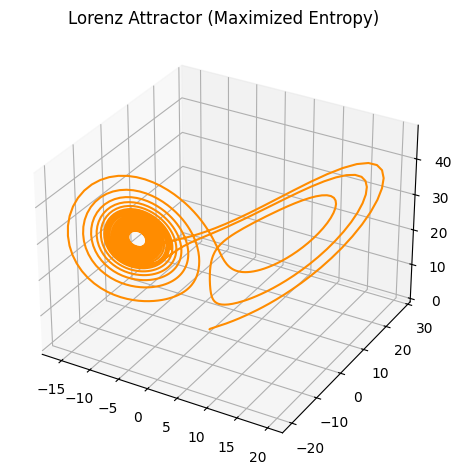

Final entropy: 2.0733167093587035
Initial state used: [0.10542652 0.0002838  0.        ]


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import entropy


# Lorenz equations in NumPy
def lorenz_step(state, sigma=10.0, rho=28.0, beta=8/3):
    x, y, z = state[..., 0], state[..., 1], state[..., 2]
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return np.stack([dx, dy, dz], axis=-1)


# Runge-Kutta integration
def simulate_lorenz_np(initial_state, dt=0.01, steps=2000):
    state = np.array(initial_state)
    trajectory = np.zeros((steps, 3))
    for i in range(steps):
        k1 = lorenz_step(state)
        k2 = lorenz_step(state + 0.5 * dt * k1)
        k3 = lorenz_step(state + 0.5 * dt * k2)
        k4 = lorenz_step(state + dt * k3)
        state = state + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)
        trajectory[i] = state
    return trajectory

# Entropy estimation using histogram
def entropy_3d(signal, bins=30):
    hist, _ = np.histogramdd(signal, bins=bins, density=True)
    p = hist[hist > 0]
    return -np.sum(p * np.log(p))  # Shannon entropy

def entropy_loss(signal):
    S = entropy_3d(signal)
    return 0.5 * S**2

# Objective function for entropy maximization
def objective_entropy_max(initial_state):
    signal = simulate_lorenz_np(initial_state)
    return -entropy_loss(signal)  # Maximize entropy = minimize negative entropy

# Run optimization
initial_guess = [0.1, 0.0, 0.0]
result = minimize(objective_entropy_max, initial_guess, bounds=[(-30, 30), (-30, 30), (0, 50)], method='Nelder-Mead')

# Simulate and plot
final_traj = simulate_lorenz_np(result.x)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(final_traj[:, 0], final_traj[:, 1], final_traj[:, 2], color='darkorange')
ax.set_title("Lorenz Attractor (Maximized Entropy)")
plt.tight_layout()
plt.show()

print("Final entropy:", entropy_3d(final_traj))
print("Initial state used:", result.x)
